# comments

Оценка памяти по суммарному значению **`pss`**

**pss** (“Proportional Set Size”) - this is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it. *I.e. if a process has 10 MBs all to itself and 10 MBs shared with another process its PSS will be 15 MBs.*

[psutil.memory_full_info](https://psutil.readthedocs.io/en/latest/index.html#psutil.Process.memory_full_info)

---

**Дочерние процессы агрегируются с родительским и считается сумма по мамяти. На графике в скобках указано количество дочерних процессов.**

# Imports

In [1]:
import os
from datetime import datetime
import time

import pandas as pd
import psutil
from typing import Literal

In [2]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns

In [3]:
psutil_version = psutil.__version__
assert psutil_version >= '6.0.0', f'\nНеобходима версия psutol не ниже 6.0.0.\nТекущая версия = {psutil_version}'

# Settings

In [4]:
# APPLY_PROCESS_NAMES = ["python", "java"]
APPLY_PROCESS_NAMES = ["python"]

UNITS: Literal["KB", "MB", "GB"] = "MB"

# Utils

In [5]:
UNITS_INFO = {
    "KB": {"name": "KB", "divider": 2**10},
    "MB": {"name": "MB", "divider": 2**20},
    "GB": {"name": "GB", "divider": 2**30}
}

In [6]:
def get_process():
    psutil.process_iter.cache_clear()
    processes = []
    df_res = pd.DataFrame()

    for proc in psutil.process_iter(['ppid', 'pid', 'name']):
        try:
            process = proc.info
            if not process["name"] in APPLY_PROCESS_NAMES or process["pid"] == os.getpid():
                continue
            process[f"memory pss {UNITS_INFO[UNITS]['name']}"] =\
                proc.memory_full_info().uss / UNITS_INFO[UNITS]['divider']
            process["cpu_percent"] = proc.cpu_percent(interval=1)
            process["cmdline"] = " ".join(proc.cmdline())
            processes.append(process)
        except:
            continue

    df_res = pd.concat([df_res, pd.DataFrame(processes)])
    df_res["parent"] = df_res["pid"].apply(lambda x: x in df_res["ppid"].values)
    df_res["child"] = df_res["ppid"].apply(lambda x: x in df_res["pid"].values and x > 10)
    df_res["id"] = df_res["pid"].mask((~df_res["parent"]) & (df_res["child"]), df_res["ppid"])
    df_res = (
        df_res
        .groupby("id")[[
            "cpu_percent",
            f"memory pss {UNITS_INFO[UNITS]['name']}",
            "child"
        ]].agg("sum")
        .join(df_res[["pid", "name", "cmdline"]].set_index("pid"), how="left")
        .reset_index()
    )
    df_res["datetime"] = datetime.now()
    df_res["id_name"] = df_res["id"].astype(str) + " - " + df_res["name"]
    
    return df_res

In [7]:
def system_monitor(df, cache={"start_time": time.perf_counter()}):
    df_monitor = df.copy()
    df_monitor["child_max"] = df_monitor.groupby("id_name")["child"].transform("max")
    df_monitor["id_name"] = df_monitor["id_name"] + " (" + df_monitor["child_max"].astype(str) + ")"

    fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=(4, 3), sharex=True)
    plt.subplots_adjust(hspace=0.02)
    fig.set_figwidth(16)
    fig.set_figheight(16)
    fig.set_facecolor("white")

    sns.lineplot(
        df_monitor, x="datetime", y=f"memory pss {UNITS_INFO[UNITS]['name']}",
        hue="id_name", palette="tab10", ax=ax1
    )
    sns.lineplot(df_monitor, x="datetime", y="cpu_percent", hue="id_name", palette="tab10", ax=ax2)
    # ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
    for ax in (ax1, ax2):
        ax.grid(which="major", linestyle=":")
        ax.legend(loc="upper left", fontsize=8)

    hour = int((time.perf_counter() - cache.get("start_time")) // 3600)
    plt.savefig(f"system_monitor_{hour}", bbox_inches="tight")
    plt.show()

---

---

# Preview

In [8]:
total_memory = psutil.virtual_memory().total / 1024**3
print(f"Total memory = {total_memory} GB")

Total memory = 13.563606262207031 GB


In [9]:
df = get_process()

In [10]:
df

,id,cpu_percent,memory pss MB,child,name,cmdline,datetime,id_name
0,6095,0.0,47.457031,0,python,/home/oleg/miniconda3/envs/recsys/bin/python -...,2025-05-24 10:52:22.171597,6095 - python
1,6103,0.0,47.503906,0,python,/home/oleg/miniconda3/envs/recsys/bin/python -...,2025-05-24 10:52:22.171597,6103 - python
2,6105,43.9,320.097656,0,python,/home/oleg/miniconda3/envs/recsys/bin/python -...,2025-05-24 10:52:22.171597,6105 - python


In [11]:
for index, values in df[["id_name", "cmdline"]].iterrows():
    print(values["id_name"])
    print("-"*len(values["id_name"]))
    print(values['cmdline'])
    print('\n')

6095 - python
-------------
/home/oleg/miniconda3/envs/recsys/bin/python -m ipykernel_launcher --f=/run/user/1000/jupyter/runtime/kernel-v36fb89f9dad90a5f092bc5f569358dfaa9fd85f83.json


6103 - python
-------------
/home/oleg/miniconda3/envs/recsys/bin/python -m ipykernel_launcher --f=/run/user/1000/jupyter/runtime/kernel-v3654a0536698ea8b722012b15aff50f0890172236.json


6105 - python
-------------
/home/oleg/miniconda3/envs/recsys/bin/python -m ipykernel_launcher --f=/run/user/1000/jupyter/runtime/kernel-v39dde5e31a0fe4fd0ab1b47f6fc79c462ccbffb61.json




# Monitoring

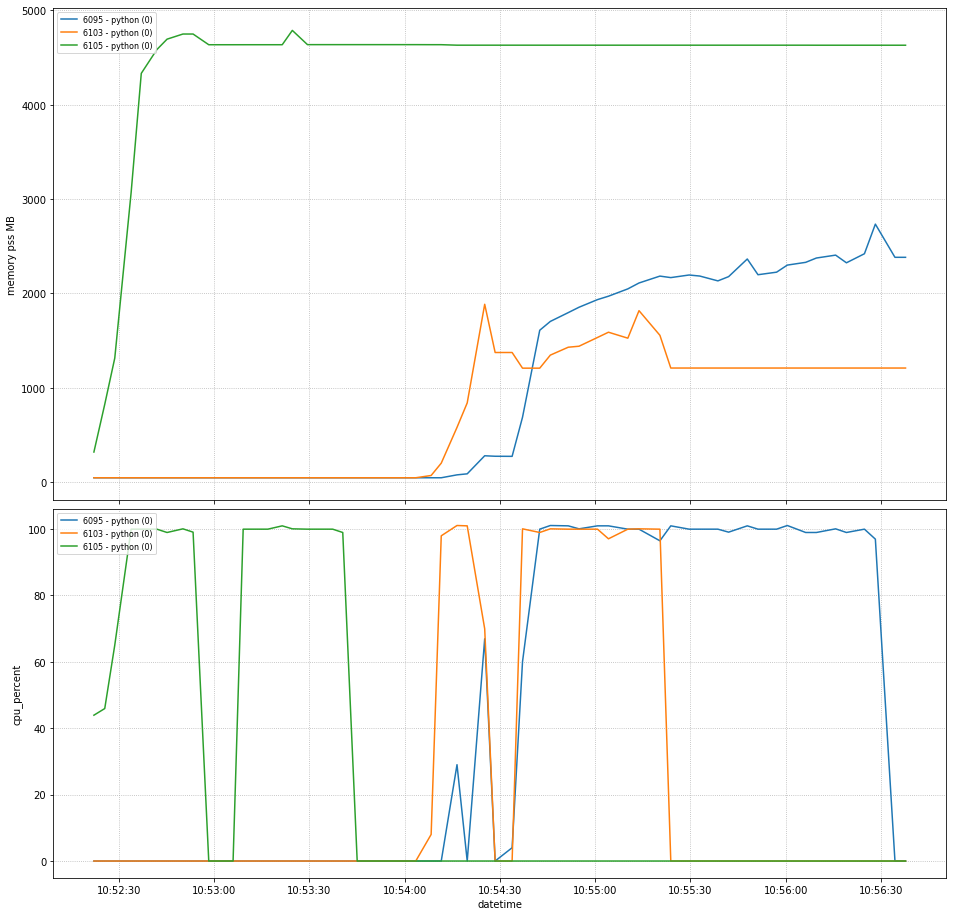

In [ ]:
while True:
# for _ in range(3):
    for _ in range(2):
        # time.sleep(10)
        df_new = get_process()
        df = pd.concat([df, df_new], ignore_index=True)

    df_max = (
        df
        .groupby(["id", "name", "cmdline"], as_index=False)[[
            "cpu_percent", f"memory pss {UNITS_INFO[UNITS]['name']}", "child"
        ]]
        .agg("max")
    )
    df_max.to_excel("process_memory_MAX.xlsx", index=False)
    df.to_excel("process_memory.xlsx", index=False)

    system_monitor(df)
    clear_output(wait=True)